# Capstone Project Notebook
### This notebook will be used for the final project for IBM Data Science Specialization

In [158]:
import pandas as pd

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
 
import numpy as np

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [188]:
criteria = ['Palace', 'Church', 'History Museum', 'Art Museum', 'Art Gallery', 'Theater', 'Restaurant', 'Dancing', 'Beer Bar', 'Wine Bar', 'Cocktail',
              'Trail', 'Mountain', 'Lake', 'Beach', 'Park', 'Concert Hall', 'Music & Shows', 'Stadium', 'Ski Area', 'National Park', 'River', 
              'Gourmet', 'Historic site', 'Snorkeling']

cities = ['Paris', 'Prague', 'London', 'Rome', 'Budapest', 'Bangkok', 'Granada', 'Vienna', 'Amsterdam', 'Buenos Aires', 'New York', 
          'Rio de Janeiro', 'Tokyo', 'Los Angeles', 'Istambul', 'Florence', 'Barcelona', 'Berlin', 'Toronto', 'Bariloche', 'Lima', 
          'Hong Kong', 'New Delhi', 'Shanghai', 'Pekin', 'Seoul', 'Borneo', 'Bali', 'Hanoi', 'Mumbai', 'Taipei', 'Kathmandu',
          'Manila', 'Sydney', 'Melbourne', 'Noumea', 'Cairo', 'Nairobi', 'Cape Town', 'Marrakech', 'Guadalajara', 'Santa Marta', 
          'Cartagena', 'Arequipa', 'Recife', 'Manaus', 'Ushuaia', 'Mendoza', 'Isla de Pascua', 'Iquique', 'Valparaiso', 'Bagan', 'Sochi']

countries = ['France', 'Czech Republic', 'United Kingdom', 'Italy', 'Hungary', 'Thailand', 'Spain', 'Austria', 'Netherlands', 'Argentina', 
             'United States', 'Brazil', 'Japan', 'United States', 'Turkey', 'Italy', 'Spain', 'Germany', 'Canada', 'Argentina', 'Peru', 
             'Hong Kong', 'India', 'China', 'China', 'South Korea', 'Malaysia', 'Indonesia', 'Vietnam', 'India', 'Taiwan', 'Nepal',
             'Philippines', 'Australia', 'Australia', 'New Caledonia', 'Egypt', 'Kenya', 'South Africa', 'Morocco', 'Mexico', 'Colombia',
             'Colombia', 'Peru', 'Brazil', 'Brazil', 'Argentina', 'Argentina', 'Chile', 'Chile', 'Chile', 'Myanmar', 'Russia']

In [189]:
len(countries)

53

In [190]:
len(cities)

53

In [191]:
len(criteria)

25

In [121]:
# Foursquare Credentials
CLIENT_ID = '2KK1DY5UHRPGZUJSUYQWKVLDHQYQJPAZ114R5DTIA1RDR15K'
CLIENT_SECRET = 'TDQE4UVYHJMB4KMZW0MFYRWXW3W5Y4SJX5VBTV4CMJ4IUNFN'
VERSION = '20181111' # Foursquare API version
LIMIT=50

In [111]:
# function that extracts comma separated categories of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    result = []
    
    for i in range(len(categories_list)):
        result.append(categories_list[i]['name'])
        
    return ', '.join(result)

In [ ]:
# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

columns = ['venue_id', 'name', 'category', 'lat', 'long', 'keyword', 'city', 'country', 'city_location']

all_venues = pd.DataFrame(columns = columns)

for i, city in enumerate(cities):
    where = '{}, {}'.format(city, countries[i])
    for keyword in criteria:
        # URL Parameters
        # near = A string naming a place in the world. I will use this parameter instead of ll (latitude, longitude)
        # query = A term to be searched against a venue’s tips, category, etc.
        # radius = if not specified, a suggested radius will be used based on the density of venues in the area.
        # time = any. Pass any to retrieve results for any time of day. Omitting this parameter returns results targeted to the current time of day.
        # day = any. Pass any to retrieve results for any day of the week. Omitting this parameter returns results targeted to the current day of the week.
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&near={}&query={}&v={}&limit={}&time=any&day=any'.format(CLIENT_ID, CLIENT_SECRET, where, keyword, VERSION, LIMIT)

        results = requests.get(url).json()
        
        if len(results['response']) == 0:
            if 'errorDetail' in results['meta']:
                if 'boundary is too big' in results['meta']['errorDetail']:
                    print('{}, keyword = {}. Boundary too big for search'.format(where, keyword))
                    continue
            print('{}, keyword = {}. No response field'.format(where, keyword))
            continue

        if 'groups' not in results['response']:
            print('{}, keyword = {}. No groups field in response'.format(where, keyword))
            continue

        if 'items' not in results['response']['groups'][0]:
            print('{}, keyword = {}. No items field in groups'.format(where, keyword))
            continue
        
        venues = results['response']['groups'][0]['items']
        
        # If the list is empty it means that no results were found. So proceed to the next search.
        if not venues:
            continue
        
        try:
            pos = results['response']['geocode']['center']
            city_loc = '{}, {}'.format(pos['lat'], pos['lng'])
        except:
            print('{}, keyword = {}. No coordinates found'.format(where, keyword))
            continue
                
        venues = json_normalize(venues) # flatten JSON

        nearby_venues = venues.loc[:, filtered_columns]
        
        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)        
        nearby_venues['keyword'] = keyword
        nearby_venues['city'] = city
        nearby_venues['country'] = countries[i]
        nearby_venues['city_location'] = city_loc

        nearby_venues.columns = columns
        
        all_venues = all_venues.append(nearby_venues[:20])

In [16]:
v_ids = df_venues.venue_id.drop_duplicates()

In [17]:
v_ids.shape

(12558,)

In [ ]:
columns = ['venue_id', 'rating', 'rating_count', 'tip_count', 'likes_count']

df_venues_scores = pd.DataFrame(columns=columns).set_index('venue_id')

for i, venue_id in enumerate(v_ids):
    print('Venue number {}. ID = {}'.format(i, venue_id))
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    resp = requests.get(url).json()

    if 'response' not in resp:
        print('No response key')
        break

    if 'venue' not in resp['response']:
        print('No venue key')
        break
    
    r = resp['response']['venue']
    
    venue = []
    
    venue.append(r.get('rating', np.nan))
    venue.append(r.get('ratingSignals', np.nan))
    venue.append(r['stats'].get('tipCount', np.nan))
    
    if 'likes' in r: 
        venue.append(r['likes'].get('count', np.nan))
    else:
        venue.append(np.nan)

    if (r['id'].strip() == venue_id.strip()):
        df_venues_scores.loc[venue_id] = venue
    else:
        print('Error with the ids. Requested: {}'.format(venue_id.strip()))
        print('Error with the ids. Response: {}'.format(r['id'].strip()))
        break

In [184]:
df_venues_scores.head()

,rating,rating_count,tip_count,likes_count
venue_id,,,,
4adcda09f964a520df3321e3,9.2,4484.0,753.0,3686.0
4bc08f79461576b014487a32,9.0,281.0,12.0,250.0
4be58f71cf200f474d57133c,8.8,303.0,14.0,260.0
4cb5f18de262b60cb95a6be0,7.6,17.0,2.0,15.0
4adcda09f964a520e83321e3,9.6,9207.0,962.0,8165.0


Now we will only keep the venues whose categories match with the search keyword 

In [163]:
# function that filter rows of a given keyword that contains keeping_words in the category column 
def clean_categories(keyword, keeping_words, df, cleaning_type='contain'):
    if cleaning_type == 'exact':
        cond = (df.category == keeping_words)
    else:
        cond = df.category.str.contains(keeping_words[0], na = False)

        if cleaning_type == 'not-contain':
            for word in keeping_words[1:]:
                cond = cond & ~(df.category.str.contains(word, na = False))
        else:
            for word in keeping_words[1:]:
                cond = cond | (df.category.str.contains(word, na = False))
                
    cond = (df.keyword != keyword) | cond
    df.drop(df[~cond].index, inplace=True)


In [164]:
clean_categories('Palace', ['Palace'], df_venues)
clean_categories('Church', ['Church'], df_venues)
clean_categories('Art Gallery', ['Art Gallery'], df_venues)
clean_categories('Theater', ['Theater', 'Opera', 'Comedy'], df_venues)
clean_categories('Restaurant', ['Restaurant'], df_venues)
clean_categories('Dancing', ['Dancing', 'Music Venue', 'Pub', 'Nightclub', 'Bar', 'Club'], df_venues)
clean_categories('Beer Bar', ['Bar'], df_venues)
clean_categories('Wine Bar', ['Wine Bar'], df_venues)
clean_categories('Cocktail', ['Cocktail', 'Bar'], df_venues)
clean_categories('Trail', ['Trail', 'Forest', 'Nature', 'Hill', 'Mountain', 'National Park'], df_venues)
clean_categories('Mountain', ['Mountain'], df_venues)
clean_categories('Lake', ['Lake', 'Garden', 'Park', 'Nature'], df_venues)
clean_categories('Park', ['Park', 'Nature', 'Garden', 'Plaza', 'Outdoors'], df_venues)
clean_categories('Concert Hall', ['Concert Hall', 'Opera', 'Music Venue', 'Auditorium'], df_venues)
clean_categories('Stadium', ['Stadium', 'Tennis', 'Court', 'Soccer', 'Arena', 'Sport', 'Football', 'Field'], df_venues)
clean_categories('National Park', ['National Park', 'Nature Preserve'], df_venues)
clean_categories('Gourmet', ['Gourmet'], df_venues)
clean_categories('Historic site', ['Historic Site', 'Monument', 'Landmark'], df_venues)
clean_categories('Ski Area', ['Ski'], df_venues)
clean_categories('Music & Shows', ['Music Venue', 'Club', 'Bar', 'Hall', 'Pub', 'Nightclub', 'Cultur'], df_venues)

clean_categories('History Museum', ['Museum', 'Art Museum'], df_venues, 'not-contain')
clean_categories('Art Museum', ['Museum', 'History Museum'], df_venues, 'not-contain')

clean_categories('River', 'River', df_venues, 'exact')
clean_categories('Beach', 'Beach', df_venues, 'exact')

cond = (df_venues.keyword != 'Snorkeling') | (~df_venues.category.str.contains('Shop', na = False))
df_venues.drop(df_venues[~cond].index, inplace=True)

In [186]:
df_venues.shape

(13150, 9)

In [166]:
df_venues.head()

,venue_id,name,category,lat,long,keyword,city,country,city_location
0,4adcda09f964a520df3321e3,Château de Versailles,Palace,48.804729,2.120340,Palace,Paris,France,"48.85341, 2.3488"
1,4bc08f79461576b014487a32,Petit Trianon,Palace,48.815222,2.109872,Palace,Paris,France,"48.85341, 2.3488"
2,4be58f71cf200f474d57133c,Grand Trianon,Palace,48.814213,2.104874,Palace,Paris,France,"48.85341, 2.3488"
15,4cb5f18de262b60cb95a6be0,Château de Guermantes,Palace,48.852891,2.697893,Palace,Paris,France,"48.85341, 2.3488"
20,4adcda09f964a520e83321e3,Cathédrale Notre-Dame de Paris,Church,48.853124,2.349561,Church,Paris,France,"48.85341, 2.3488"


In [168]:
df_venues_detail = df_venues.join(df_venues_scores, on='venue_id')

In [169]:
# Removing ratings, likes and tips with NaN values
condition = df_venues_detail['rating'].isnull() & df_venues_detail['rating_count'].isnull() & df_venues_detail['tip_count'].isnull() & df_venues_detail['likes_count'].isnull()
df_venues_detail = df_venues_detail[~condition]

In [187]:
df_venues_detail.shape

(9504, 13)

In [18]:
df_venues_detail.describe()

,lat,long,rating,rating_count,tip_count,likes_count
count,9504.000000,9504.000000,9504.000000,9504.000000,9504.000000,9502.000000
mean,21.746504,20.870133,8.160311,310.966014,49.259049,249.648916
std,29.449104,77.401176,0.919509,1073.636315,126.636901,925.125229
min,-54.834857,-118.606978,4.700000,1.000000,0.000000,0.000000
25%,-3.070949,-43.220070,7.600000,23.000000,5.000000,17.000000
50%,34.275262,13.403907,8.300000,69.000000,14.000000,52.000000
75%,43.654203,105.770267,8.900000,224.000000,43.000000,170.000000
max,52.623177,166.482182,9.800000,26225.000000,2738.000000,22968.000000


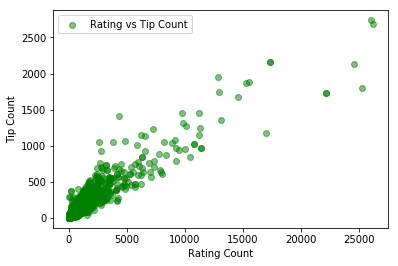

In [178]:
import matplotlib.pyplot as plt

x = df_venues_detail['rating_count'].values
y = df_venues_detail['tip_count'].values

plt.scatter(x, y, c="g", alpha=0.5, 
            label="Rating vs Tip Count")
plt.xlabel("Rating Count")
plt.ylabel("Tip Count")
plt.legend(loc='upper left')
plt.show()

In [173]:
df_venues_detail['tip_count'].corr(df_venues_detail['rating_count'])

0.93246485206500362

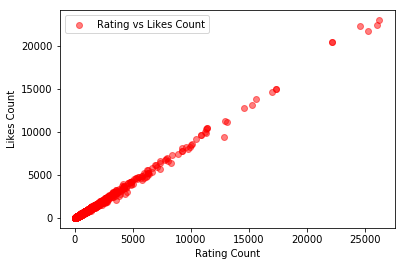

In [174]:
x = df_venues_detail['rating_count'].values
y = df_venues_detail['likes_count'].values

plt.scatter(x, y, c="r", alpha=0.5, 
            label="Rating vs Likes Count")
plt.xlabel("Rating Count")
plt.ylabel("Likes Count")
plt.legend(loc='upper left')
plt.show()

In [175]:
df_venues_detail['likes_count'].corr(df_venues_detail['rating_count'])

0.99812548531479939

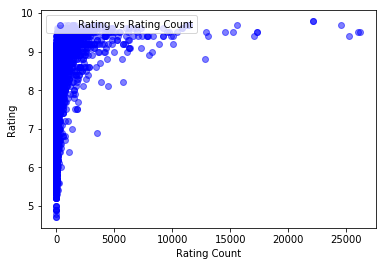

In [176]:
x = df_venues_detail['rating_count'].values
y = df_venues_detail['rating'].values

plt.scatter(x, y, c="b", alpha=0.5, 
            label="Rating vs Rating Count")
plt.xlabel("Rating Count")
plt.ylabel("Rating")
plt.legend(loc='upper left')
plt.show()

In [177]:
df_venues_detail['rating'].corr(df_venues_detail['rating_count'])

0.26667196713801883

In [181]:
def compute_score(frame):
    x = (frame.rating * frame.rating_count)
    return np.sum(x)

cities_score = df_venues_detail.groupby(['country', 'city', 'keyword']).apply(compute_score).reset_index()
cities_score = cities_score.rename(columns={0:'score'})
cities_score = cities_score.sort_values(['country', 'city', 'score'], ascending = [True, True, False])

In [182]:
cities_score.head(10)

,country,city,keyword,score
9,Argentina,Bariloche,Ski Area,8297.2
8,Argentina,Bariloche,Restaurant,7478.6
5,Argentina,Bariloche,Mountain,4403.1
11,Argentina,Bariloche,Trail,2202.8
3,Argentina,Bariloche,Dancing,1621.3
0,Argentina,Bariloche,Beach,1132.1
6,Argentina,Bariloche,National Park,841.4
1,Argentina,Bariloche,Beer Bar,596.8
4,Argentina,Bariloche,History Museum,204.0
10,Argentina,Bariloche,Theater,121.8


In [97]:
v = cities_score.loc[cities_score['keyword'] == 'Ski Area']
v = v.sort_values('score', ascending = False)
v

,country,city,keyword,score
698,Russia,Sochi,Ski Area,17770.8
9,Argentina,Bariloche,Ski Area,8297.2
51,Argentina,Ushuaia,Ski Area,2320.5
418,Hungary,Budapest,Ski Area,1690.7
845,Turkey,Istambul,Ski Area,1254.1
867,United Kingdom,London,Ski Area,915.2
252,China,Pekin,Ski Area,791.4
911,United States,New York,Ski Area,180.8
575,Mexico,Guadalajara,Ski Area,118.5
193,Canada,Toronto,Ski Area,110.6


In [56]:
keywords = cities_score.keyword.unique()

columns = np.concatenate([['country', 'city'], keywords])

df_cities_info = pd.DataFrame(columns = columns)
df_cities_info

,country,city,Ski Area,Restaurant,Mountain,Trail,Dancing,Beach,National Park,Beer Bar,History Museum,Theater,Cocktail,Park,Concert Hall,Historic site,Stadium,Art Museum,Art Gallery,Wine Bar,Music & Shows,Lake,River,Gourmet,Church,Snorkeling,Palace


In [57]:
df_cc = cities_score.drop_duplicates(subset=['country', 'city'], keep='first', inplace=False)[['country', 'city']]

for index, row in df_cc.iterrows():
    dict1 = {'country': row.country, 'city': row.city}
    dict2 = dict(zip(keywords, [0] * len(keywords)))
    element = dict(dict1, **dict2)
    
    for i, r in cities_score.loc[(cities_score.country == row.country) & (cities_score.city == row.city)].iterrows():
        element[r.keyword] = r.score

    df_cities_info = df_cities_info.append(element, ignore_index=True)


In [58]:
df_cities_info.tail(10)

,country,city,Ski Area,Restaurant,Mountain,Trail,Dancing,Beach,National Park,Beer Bar,History Museum,Theater,Cocktail,Park,Concert Hall,Historic site,Stadium,Art Museum,Art Gallery,Wine Bar,Music & Shows,Lake,River,Gourmet,Church,Snorkeling,Palace
43,South Korea,Seoul,0.0,16319.5,4027.3,9218.9,6818.2,0.0,916.1,10970.3,25337.2,7472.6,10847.1,44268.3,12438,32282.5,20930.7,34232.8,10688.7,5509.8,808,5771.6,4035.4,7811.6,83,0,15531.7
44,Spain,Barcelona,0.0,108652.6,16280.1,7122.3,49002.6,90567.9,1101.1,40006.7,23907.8,27034.8,78289.6,127448.2,77783,134356,125577,98141.3,26566.5,40761.7,4392,37928,1161.6,4363.2,124873,65449.9,1896.5
45,Spain,Granada,0.0,21185.4,85.8,212.5,4902.5,0.0,0.0,623.1,3166.5,508.0,2062.3,3627.7,1033.2,38988.4,1623.5,1673.5,486.3,9503.2,1857.6,0,0,286.7,1284.8,0,5462.5
46,Taiwan,Taipei,0.0,33887.4,3905.7,5935.4,4745.6,0.0,2145.5,3510.3,11959.8,3242.0,12550.9,17183.8,1929.1,8931.2,3297.7,5590.2,7546.1,2099.5,1951.7,4952.9,0,667.4,0,0,0
47,Thailand,Bangkok,0.0,38135.7,0.0,0.0,46199.8,603.1,0.0,9724.5,14291.3,10773.8,36428.3,58634.9,8669.2,31231.9,17535.2,26662.6,29717.9,22993.2,179.2,5984.2,0,5155.1,445.4,0,30280
48,Turkey,Istambul,1254.1,71012.1,33198.6,51574.8,279010.0,127262.2,5695.7,169012.7,322493.5,134503.7,221874.3,313898.7,252161,956187,638383,73869.1,70020.2,146464,0,41256.6,1383.4,152578,680.8,0,190855
49,United Kingdom,London,915.2,128013.3,0.0,8672.1,48516.9,404.0,0.0,63987.5,216692.1,91380.8,95014.5,315021.1,81291.7,120601,96282.5,238890,86533.6,35732.2,67760.6,221403,190.4,25829.3,39730.4,567.3,91426.4
50,United States,Los Angeles,0.0,65529.6,2449.9,41354.7,42453.8,116928.9,0.0,24863.0,27135.0,68000.8,51728.3,30570.5,102432,46811.9,91413.1,93118.7,13677.3,45401.4,47531.4,10733.4,77,11214.2,1391.7,0,0
51,United States,New York,180.8,120556.4,0.0,35629.6,115253.9,79.2,1616.0,108589.8,180365.2,125928.7,175136.3,711435.5,117648,203078,94427,459050,29678.4,72152.5,12429.4,232647,1488.2,159572,33058.1,0,0
52,Vietnam,Hanoi,0.0,12956.9,54.0,0.0,4109.9,0.0,0.0,1872.9,5835.2,2558.3,3522.0,2309.3,1577.9,10960.9,442.2,608.4,1650.5,4739.2,490.3,818.8,0,117.3,118.4,0,684


In [51]:
df_cities_info

,country,city,Ski Area,Restaurant,Mountain,Beach,National Park,Park,River,Snorkeling,labels,Beer,Nightclub,History,Art,Concerts,Music Shows,Architecture
0,Argentina,Bariloche,8297.2,7478.6,6605.9,1132.1,841.4,100.5,0,0,0,596.8,1726.3,204,0,121.8,0,0
1,Argentina,Buenos Aires,0.0,115147,52.8,11146.1,0.0,58193.8,7410.3,0,0,44651.2,134181.2,100562,83746,150480,90271.6,372.2
2,Argentina,Mendoza,0.0,20436.8,69.3,0.0,0.0,7745.8,0,0,0,1902,2954.2,719.2,888.1,1713.2,1281.1,0
3,Argentina,Ushuaia,2320.5,9596.4,6574.4,0.0,1737.0,0,0,0,0,856.3,0.0,3687.5,0,0,0,0
4,Australia,Melbourne,0.0,19401,725.9,11235.2,0.0,24479.7,1960.8,0,0,34401,27089.2,14855.7,31765.2,23748.6,23227.6,0
5,Australia,Sydney,0.0,16842.3,8466.5,70669.4,1528.6,28409.7,484.3,31830.6,0,30082.1,34267.2,19648.6,25854.1,83913.2,17401.9,2684.5
6,Austria,Vienna,51.2,38001,11874.6,295.3,403.5,56687.3,0,0,0,28411.9,62704.8,128208,84603,34725.7,19466.4,109687
7,Brazil,Manaus,56.7,13306.8,1357.1,9419.6,58.4,14856.6,0,0,0,1344.5,34117.9,19430,3113.8,21150.4,15752.8,1458.8
8,Brazil,Recife,0.0,63426.7,996.7,59286.3,0.0,65973.3,0,0,0,1979.7,55822.0,97331.5,55288.8,22029,52079.4,1410.1
10,Canada,Toronto,110.6,36024.2,2283.7,11625.7,0.0,38649.7,0,0,0,56930.4,42304.6,80249.2,44312.1,39417.7,66198.2,1050.2


In [ ]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# set number of clusters
kclusters = 6

df_cities_clustering = df_cities_info.drop(['country', 'city'], 1)

X = df_cities_clustering.values[:,:]
X = np.nan_to_num(X)

cluster_dataset = StandardScaler().fit_transform(X)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_dataset)

# check cluster labels generated for each row in the dataframe
df_cities_info['labels'] = kmeans.labels_



In [62]:
df_cities_info['labels'] = kmeans.labels_

In [157]:
df_cities_info.sort_values(by = 'labels')[['country', 'city', 'labels']]

,country,city,labels
19,Egypt,Cairo,0
34,Myanmar,Bagan,0
32,Mexico,Guadalajara,0
43,South Korea,Seoul,0
44,Spain,Barcelona,0
28,Italy,Rome,0
27,Italy,Florence,0
25,India,New Delhi,0
23,Hungary,Budapest,0
21,Germany,Berlin,0
